# HW01

In [238]:
%%capture

from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn.modules import loss
from torch import optim
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from tqdm.auto import tqdm

In [239]:
torch.manual_seed(0)

In [349]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.thetas = torch.zeros(100, requires_grad=True)

    def forward(self, x):
        return torch.exp(self.thetas[x]) / torch.sum(torch.exp(self.thetas))
    
    def parameters(self):
        return [self.thetas]
    
    def __call__(self, x):
        return self.forward(x)

In [350]:
def MyNLLLoss(y):
    return -torch.sum(torch.log(y))

In [351]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [352]:
def fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size):
    val_size = len(X_val)
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    train_loss_values = []
    val_loss_values = []
        
    for epoch in tqdm(range(epoch_cnt)):
        for batch_data in train_loader:
            optimizer.zero_grad()
            output = model(batch_data)
            loss = loss_function(output)
            train_loss_values.append(loss / batch_size)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            output = model(X_val)
            loss = loss_function(output)
            val_loss_values.append(loss / val_size)

    with torch.no_grad():
        output = model(X_test)
        loss = loss_function(output)
        print("Test set loss: {:.6f}".format(loss / len(X_test)))

    return train_loss_values, val_loss_values 


In [353]:
samples = sample_data()
X_train, X_test = train_test_split(samples, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.125, random_state=42)

In [354]:
model = MyModel()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
loss_function = MyNLLLoss

In [355]:
epoch_cnt = 20
batch_size = 1000
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, loss_function, epoch_cnt, batch_size)


Test set loss: 4.072058


In [362]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / epoch_cnt), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

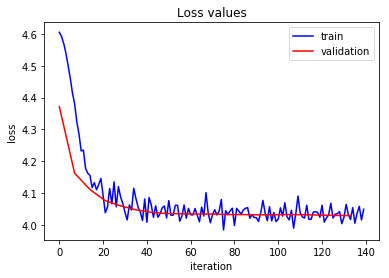

In [363]:
plot_loss_values(train_loss_values, val_loss_values)

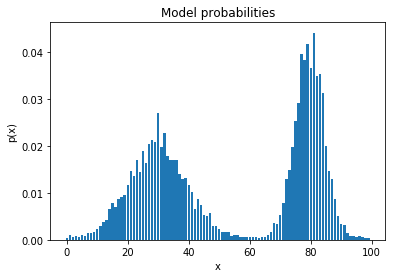

In [366]:
x = np.arange(100)
model_p = model(x)
plt.bar(x, model_p.detach().numpy())
plt.title("Model probabilities")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()

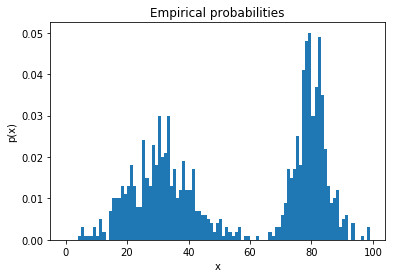

In [376]:
x = np.arange(100)
y = np.random.choice(x, size=1000, p=model_p.detach().numpy())
plt.hist(y, bins=x, density=True)
plt.title("Empirical probabilities")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()

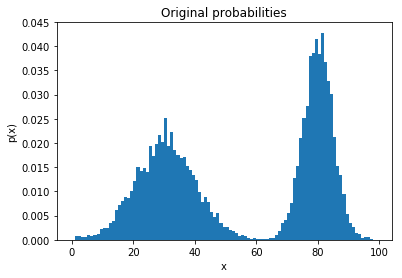

In [374]:
x = np.arange(100)
y = samples
plt.hist(y, bins=x, density=True)
plt.title("Original probabilities")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.show()